# Importing libraries and dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Understanding of the dataset

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


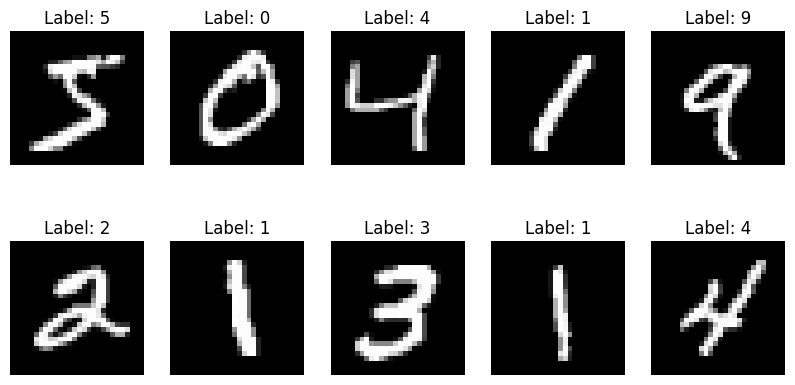

In [2]:
# Check the shape of the data arrays
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# Visualize a few sample images and their labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


# Data Processing

In [3]:
# Reshape and normalize the input data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


# EDA

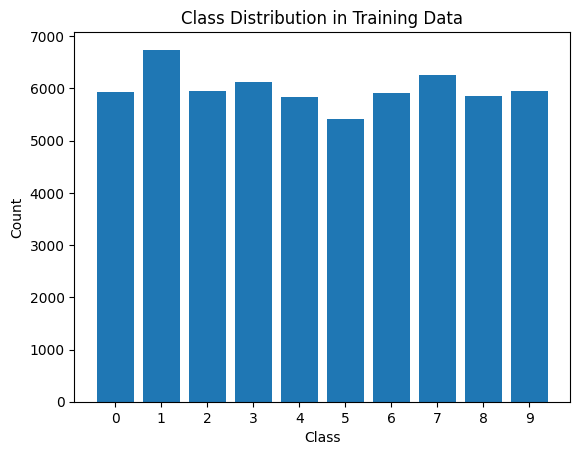

In [4]:

# Count the number of samples for each class
class_counts = np.bincount(np.argmax(y_train, axis=1))

# Plot a bar chart to visualize class distribution
plt.bar(range(10), class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(10), [str(i) for i in range(10)])
plt.title('Class Distribution in Training Data')
plt.show()


## Data Splitting

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# We perform PCA to reduce the number of dimensions

In [6]:
# Define the number of principal components to retain
n_components = 50  #PC

# Flatten the images for PCA into 1D arrays
x_train_flatten = x_train.reshape(-1, 28 * 28)
x_val_flatten = x_val.reshape(-1, 28 * 28)
x_test_flatten = x_test.reshape(-1, 28 * 28)

# Fit PCA on the training data
pca = PCA(n_components=n_components, random_state=42)
x_train_pca = pca.fit_transform(x_train_flatten)

# Transform validation and test data using the same PCA transformation
x_val_pca = pca.transform(x_val_flatten)
x_test_pca = pca.transform(x_test_flatten)

# we have reduced-dimensional representation of the data that can be used as input for our PCA-based model.


# Define a new model with PCA features as input


In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

model_pca = Sequential([
    Input(shape=(n_components,)),  # Input layer with shape equal to the number of PCA components
    Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    Dropout(0.5),  # Dropout layer with a dropout rate of 50%
    Dense(10, activation='softmax')  # Output layer with 10 units and softmax activation for multi-class classification
])


model_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with PCA features
history_pca = model_pca.fit(x_train_pca, y_train, epochs=10, batch_size=64, validation_data=(x_val_pca, y_val))


Epoch 1/10
750/750 [==============================] - 3s 2ms/step - loss: 0.6787 - accuracy: 0.7952 - val_loss: 0.2659 - val_accuracy: 0.9250
Epoch 2/10
750/750 [==============================] - 1s 2ms/step - loss: 0.3328 - accuracy: 0.9019 - val_loss: 0.2058 - val_accuracy: 0.9389
Epoch 3/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2728 - accuracy: 0.9174 - val_loss: 0.1744 - val_accuracy: 0.9498
Epoch 4/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2446 - accuracy: 0.9275 - val_loss: 0.1556 - val_accuracy: 0.9550
Epoch 5/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2236 - accuracy: 0.9342 - val_loss: 0.1388 - val_accuracy: 0.9601
Epoch 6/10
750/750 [==============================] - 1s 2ms/step - loss: 0.2054 - accuracy: 0.9395 - val_loss: 0.1300 - val_accuracy: 0.9628
Epoch 7/10
750/750 [==============================] - 1s 2ms/step - loss: 0.1939 - accuracy: 0.9422 - val_loss: 0.1229 - val_accuracy: 0.9628
Epoch 

# confusion_matrix

313/313 [==============================] - 0s 1ms/step


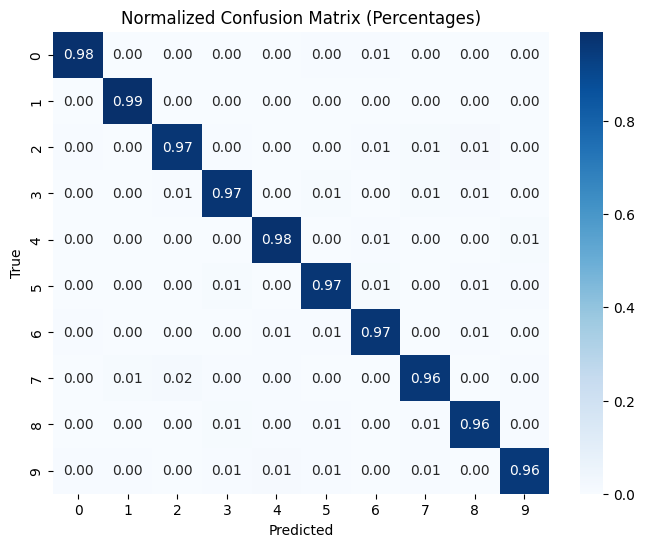

In [11]:
# Get predictions from the PCA model
y_pred_pca = model_pca.predict(x_test_pca)

# Convert one-hot encoded labels back to single values
y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred_pca, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_single, y_pred_single)

# Normalize the confusion matrix to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the confusion matrix using a heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt=".2f", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Percentages)')
plt.show()



# Missclassified value

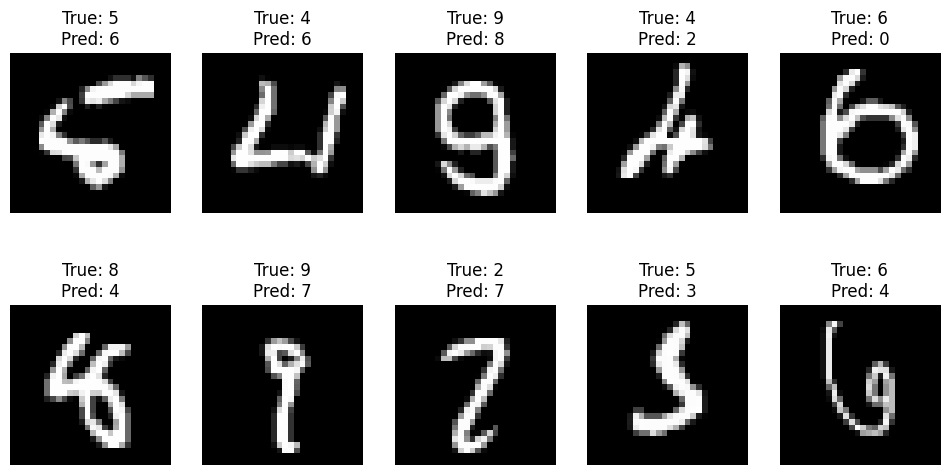

In [9]:
#example of missclassified value, we can see that the problem is not really into the model but the handwritting here is awful
misclassified_indices = np.where(y_test_single != y_pred_single)[0]

plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test_single[idx]}\nPred: {y_pred_single[idx]}")
    plt.axis('off')
plt.show()


# Understanding of how the model see the first 10 principal component as image

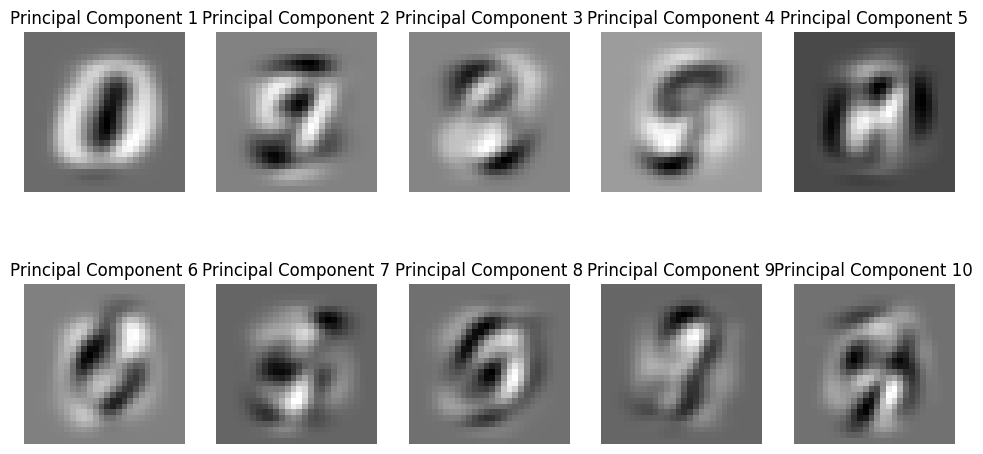

In [10]:
# Get the principal components
principal_components = pca.components_

# Visualize the first few principal components as images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(principal_components[i].reshape(28, 28), cmap='gray')
    plt.title(f"Principal Component {i + 1}")
    plt.axis('off')
plt.show()
#visual representations of the first few principal components, allowing us to see the dominant patterns or structures that each component captures in the original image data.

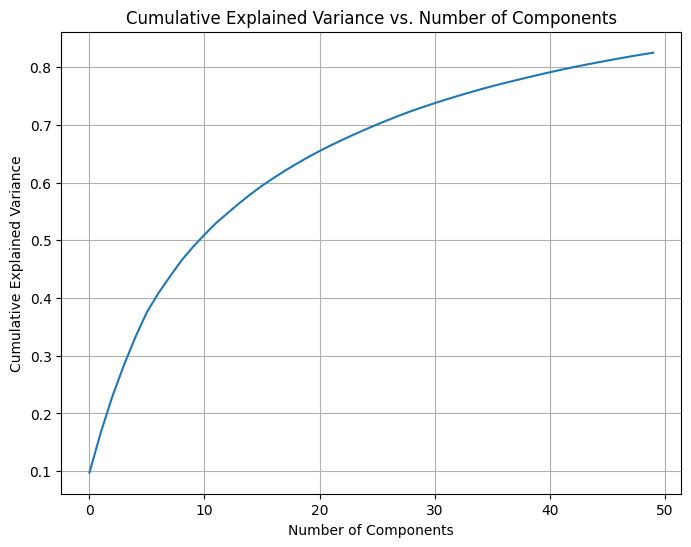

In [23]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid()
plt.show()
